In [8]:
%ls -rlth

total 2.3G
-rw-r--r-- 1 dueo dueo 1.6M Jul 28 20:14 DataHandling.ipynb
-rw-r--r-- 1 dueo dueo 2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo 2.3K Jul 28 20:24 FirstNetwork.ipynb


In [25]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline

In [15]:
start = time.time()
#with open('HCS_48x48.npz') as f:
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000633001327515


In [16]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [19]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

In [32]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

(-0.5, 3.5)

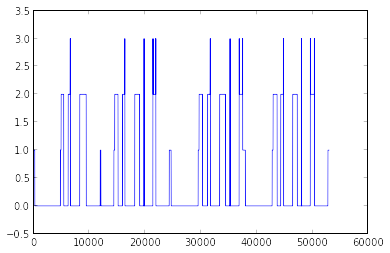

In [36]:
plt.plot(Y)
plt.ylim(-0.5,3.5)

### Normalization

In [40]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [42]:
np.min(X), np.max(X), np.mean(X)

(-2.5230029, 55.53228, 1.3684561e-07)

In [88]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

Populating the interactive namespace from numpy and matplotlib


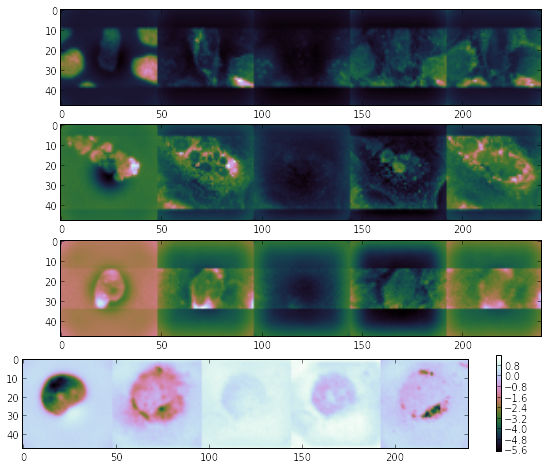

In [182]:
%pylab inline
cmap = plt.get_cmap('cubehelix')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
idx = (np.argwhere(Y == 0)[0][0], 
       np.argwhere(Y == 1)[0][0], 
       np.argwhere(Y == 2)[0][0], 
       np.argwhere(Y == 3)[0][0])
cmap = plt.get_cmap('cubehelix')
plt.subplot(511) 
plt.imshow(np.concatenate(X[idx[0],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(512) 
plt.imshow(np.concatenate(X[idx[1],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(513) 
plt.imshow(np.concatenate(X[idx[2],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.subplot(514) 
plt.imshow(np.concatenate(-X[idx[3],:,:,:],axis=1), cmap=plt.get_cmap('cubehelix'))
plt.colorbar()
plt.show()

### Splitting in training and test-set
We take all, which is  below 40000 for training and validation and images above for testing.

In [177]:
split = 40000
X_train = X[0:split,:,:,:]
Y_train = Y[0:split]
X_test = X[split:,:,:,:]
Y_test = Y[split:]

#### Permuting the training set


In [178]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:,:,:]
YY = Y_train[perm]

In [179]:
PIXELS = 48

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    dropout1_p=0.0,
    
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_pool_size=(2, 2),
    dropout2_p=0.3,
    
    hidden3_num_units=100,
    dropout3_p=0.3,
    
    hidden4_num_units=20,
    dropout4_p=0.3,
    
    output_num_units=5, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=100,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

In [180]:
net = net1.fit(XX,YY)

# Neural Network with 664753 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 5x48x48  |
|   1 | conv1    | 32x44x44 |
|   2 | pool1    | 32x22x22 |
|   3 | dropout1 | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | pool2    | 64x10x10 |
|   6 | dropout2 | 64x10x10 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 5        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.59242       0.45189      1.31099      0.83676  13.32s
      2       0.45235       0.37921      1.19289      0.86165  13.23s
      3       0.40649       0.33943      1.19755      0.88149  13.23s
      4       0.37173       0.33527      1.10876      0.88049  13.23s
      5       0.35000       0.31372      1.11564      0.89152  13.23s
      6       0.333

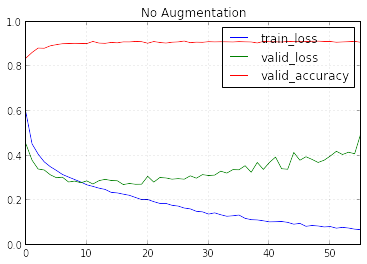

In [189]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(net.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,1))

We see a overfitting after approx 20 Epochs.

In [185]:
pred = net.predict(X_test)

In [186]:
sum(pred == Y_test)/float(len(Y_test))

0.82501930501930498

### Calucation of the confusion matrix

In [193]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,9004,60,1326,1
PACLITAXEL Pred,208,269,94,6
METOCLOPRAMIDE Pred,523,44,1291,0
DIGOXIN Pred,0,4,0,120


In [194]:
np.sum(Y_test==0)

9735